# Data Augmentation Techniques for Image Tasks

In this chapter, we will explore various data augmentation techniques that can be applied to image data to improve the performance and generalization of deep learning models. Data augmentation is a crucial step in training neural networks as it helps in creating a more diverse training dataset, which in turn can lead to better model robustness.

## Why Data Augmentation?

Data augmentation artificially expands the size of the training dataset by creating modified versions of the existing images. This helps in:
- Reducing overfitting by introducing variability in the training data.
- Improving the model's ability to generalize to unseen data.
- Making the model invariant to various transformations like rotation, translation, scaling, etc.

## Baseline

1. **RandomResizedCrop**:  RandomResizedCrop is a data augmentation technique that performs a random crop of the input image and then resizes it to a specified size. This helps in creating different variations of the same image, which can help in making the model more robust and less prone to overfitting.

2. **RandomHorizontalFlip**: RandomHorizontalFlip is a data augmentation technique that randomly flips the input image horizontally with a given probability. This is useful for augmenting images where horizontal mirroring makes sense, such as in natural scenes or some object detection tasks.

### Implementing Baseline in PyTorch

Let's implement these data augmentation techniques using PyTorch's `torchvision.transforms`. We'll define a set of transformations and apply them to the FashionMNIST dataset.

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

class PairedDataset(Dataset):
    def __init__(self, dataset, orig_transform, aug_transform):
        self.dataset = dataset
        self.orig_transform = orig_transform
        self.aug_transform = aug_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        orig_img = self.orig_transform(img)
        aug_img = self.aug_transform(img)
        return orig_img, aug_img, label


class Augment():
    def __init__(self, aug_transform):

        orig_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        base_dataset = torchvision.datasets.FashionMNIST(root='.data', train=True, download=True, transform=None)
        paired_dataset = PairedDataset(base_dataset, orig_transforms, aug_transforms)
        self.loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)
        
    def imshow(imgs, title):
        imgs = imgs / 2 + 0.5
        npimg = imgs.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(title)
        plt.show()

    def show_augment(self):
        dataiter = iter(self.loader)
        orig_images, aug_images, _ = next(dataiter)
        imshow(torchvision.utils.make_grid(orig_images), "Original Images")
        imshow(torchvision.utils.make_grid(aug_images), "Augmented Images")

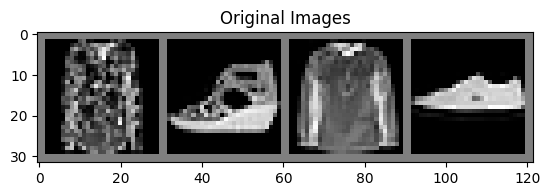

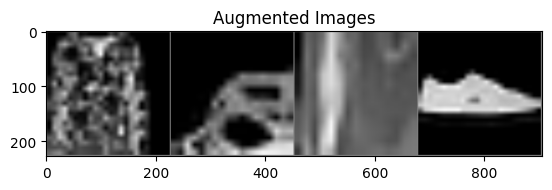

In [35]:
aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

augment = Augment(aug_transform=aug_transforms)
augment.show_augment()

## AutoAugment

Google proposed in 2018 to use AutoML to automatically search for data augmentation strategies, known as AutoAugment. The search method adopts reinforcement learning, similar to NAS, except that the search space is a data augmentation strategy, not a network architecture. In the search space, a policy contains 5 sub policies, each of which contains two serial image enhancement operations. Each enhancement operation has two hyperparameters: the probability of performing this operation and the magnitude of image enhancement (magic, which represents the strength of data enhancement. For example, for rotation, the angle of rotation is the enhancement amplitude, and the larger the rotation angle, the greater the enhancement). When executing each policy, first randomly select a sub policy from 5 policies, and then sequentially perform two image operations.

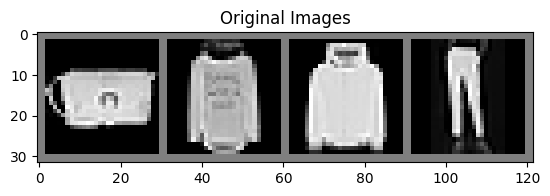

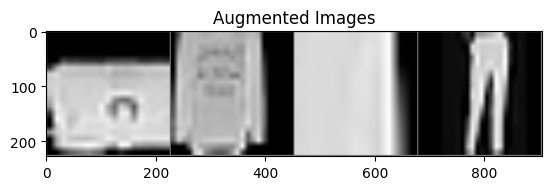

In [42]:
from torchvision.transforms import autoaugment, transforms

aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    autoaugment.AutoAugment(policy=autoaugment.AutoAugmentPolicy('imagenet')),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

augment = Augment(aug_transform=aug_transforms)
augment.show_augment()

## RandAugment

One problem with AutoAugment is the huge search space, which makes the search only possible in proxy tasks: using a small model to search a small subset of ImageNet (120 classes and 6000 images). Google proposed a simpler data augmentation strategy in 2019: RandAugment. This paper first found that AutoAugment, a strategy found on small datasets, has problems when applied on large datasets. This is mainly because there is a strong correlation between data augmentation strategies and model size and data volume. As shown in the figure below, the larger the model or training data volume, the greater the optimal data augmentation amplitude. This indicates that the results obtained by AutoAugment should be suboptimal. Additionally, The paper on Population Based Augmentation found that the optimal data augmentation amplitude increases with the training process, and different augmentation operations follow similar patterns. This inspired the author to use a fixed augmentation amplitude instead of searching. RandAugment has a smaller policy space compared to AutoAugment, so it does not require the use of proxy tasks, and even directly uses simple grid search.

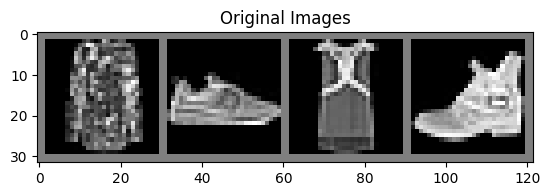

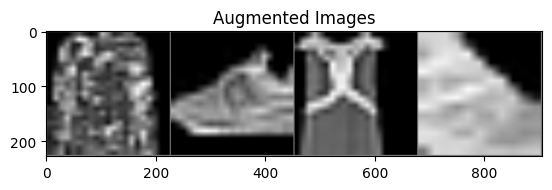

In [43]:
from torchvision.transforms import autoaugment, transforms

aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    autoaugment.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

augment = Augment(aug_transform=aug_transforms)
augment.show_augment()

## TrivialAugment

Although the search space of RandAugment is extremely small, it is still necessary to determine the optimal N and M for different datasets, which still incurs significant experimental costs. After RandAugment, Huawei proposed UniformAugment, a strategy that can achieve good results without the need for searching. However, here we introduce an updated work: TrivialAugment: Turning free yet State of the Art Data Augmentation. TrivialAugment also does not require any search, and the entire method is very simple: randomly select one image enhancement operation at a time, then randomly determine its enhancement amplitude, and enhance the image. Since there are no hyperparameters, no search is required. From the experimental results, it can be seen that, TA can achieve better results on multiple datasets, such as on the ImageNet dataset, The top 1 acc of ResNet50 can reach 78.1, surpassing RandAugment.

The image enhancement set of TrivialAugment is basically the same as RandAugment, but TrivialAugment also defines a wider set of enhancement amplitudes. Currently, Torchvision has implemented TrivialAugmentWide, and the specific usage code is as follows:

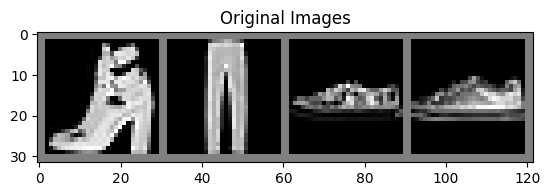

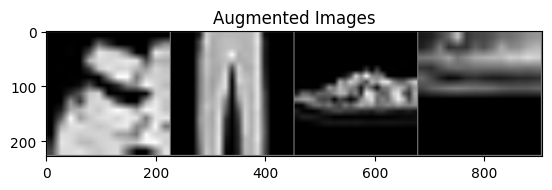

In [44]:
from torchvision.transforms import autoaugment, transforms

aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    autoaugment.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

augment = Augment(aug_transform=aug_transforms)
augment.show_augment()

## RandomErasing

RandomErasing is a simple data augmentation proposed by Xiamen University in 2017. The basic principle is to randomly erase a rectangular area from an image without changing the original label of the image.

At present, Torchvision also implements RandomErasing, and its specific usage code is as follows (note that this op does not support PIL images and needs to be used after converting to Torch.tensor):

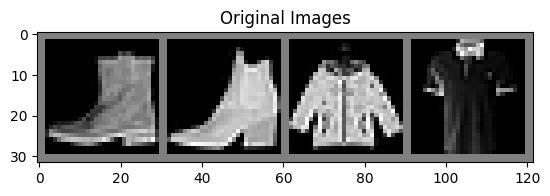

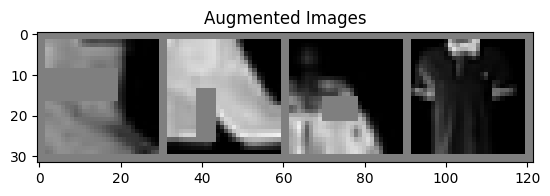

In [45]:
aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

augment = Augment(aug_transform=aug_transforms)
augment.show_augment()